In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from scipy.optimize import curve_fit, minimize
import pandas as pd
from tri_ct_tools.image.reader import singlecam_mean
from tri_ct_tools.preprocess.beam_hardening import (
    pixel_coordinates,
    d_through_column,
    cate_to_astra,
    single_cam_analysis)



In [2]:

# path to geometry
geom_path = Path(R'U:\Xray RPT ChemE\X-ray\Xray_data\2025-06-13 Rik Cropper\calib\NeedleCalibration_5degps\geom.npy')
output_path = geom_path.parent / "bhc"
output_path.mkdir(exist_ok=True)

det = {
    "rows": 1524,        # Number of rows in the detector
    "cols": 1548,        # Number of columns in the detector
    "pixel_width": 0.0198,  # Pixel width in cm
    "pixel_height": 0.0198,  # Pixel height in cm
    'det_width': 30.7, # cm, detector width
    'det_height': 30.2, # cm, detector height
    'column_inner_D' : 19, # cm
    'column_outer_D' : 20.0 # cm
}

geoms_all_cams = cate_to_astra(path=geom_path, det=det)


C:\Users\rikvolger\Codebase\3ct-tools\src\tri_ct_tools\preprocess\beam_hardening.py:216: RuntimeWarning: divide by zero encountered in log
  ln_intensity = -np.log(image_full / image_empty)
C:\Users\rikvolger\Codebase\3ct-tools\src\tri_ct_tools\preprocess\beam_hardening.py:265: RuntimeWarning: divide by zero encountered in divide
  effective_attenuation = ln_intensity / mean_distance
C:\Users\rikvolger\Codebase\3ct-tools\src\tri_ct_tools\preprocess\beam_hardening.py:265: RuntimeWarning: invalid value encountered in divide
  effective_attenuation = ln_intensity / mean_distance
C:\Users\rikvolger\Codebase\3ct-tools\src\tri_ct_tools\preprocess\beam_hardening.py:216: RuntimeWarning: invalid value encountered in divide
  ln_intensity = -np.log(image_full / image_empty)
C:\Users\rikvolger\Codebase\3ct-tools\src\tri_ct_tools\preprocess\beam_hardening.py:218: RuntimeWarning: invalid value encountered in divide
  rel_img = image_full / image_empty
C:\Users\rikvolger\Codebase\3ct-tools\src\tri_c

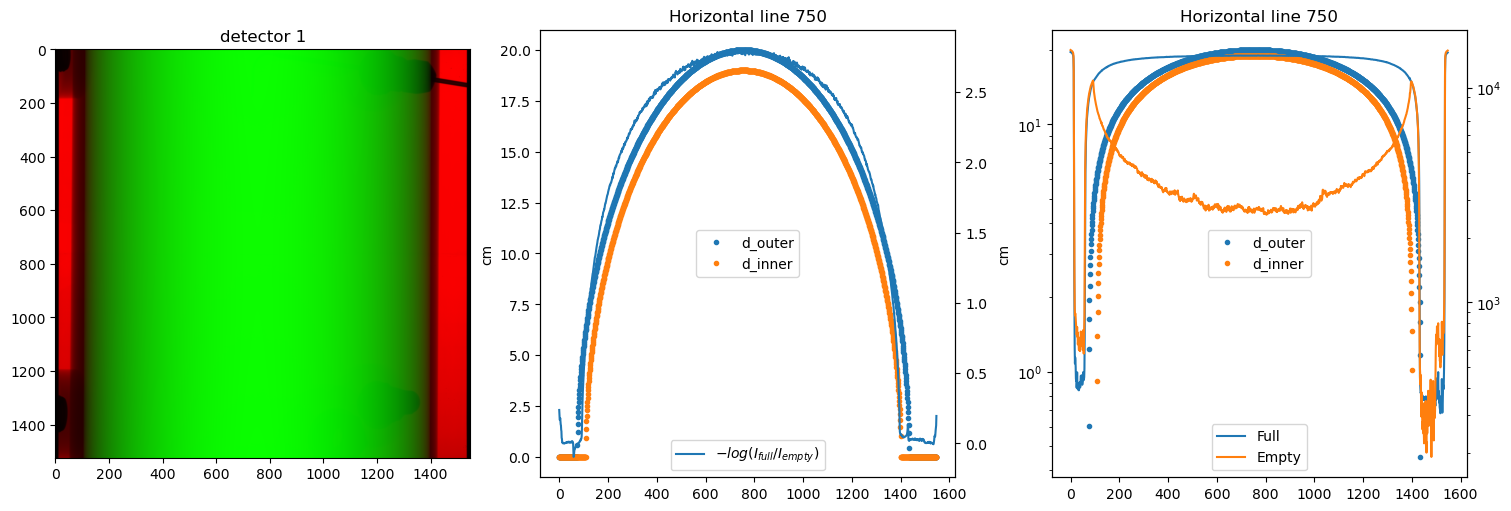

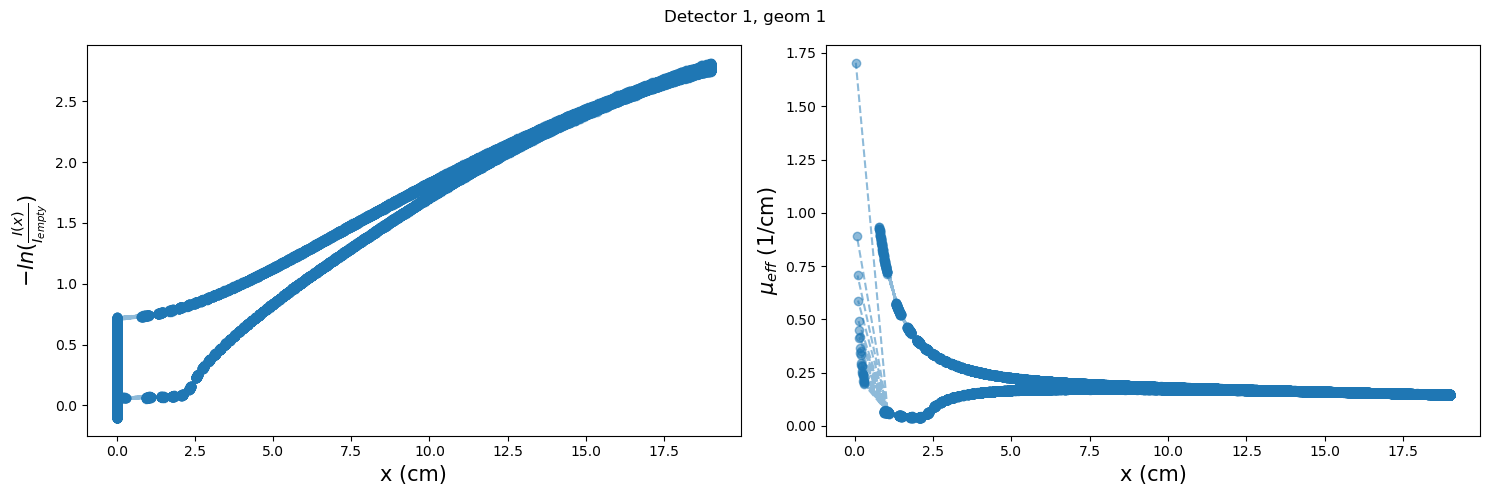

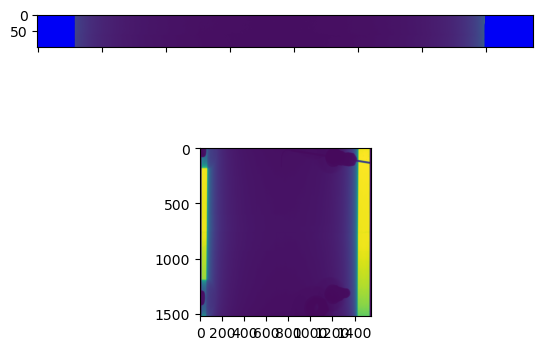

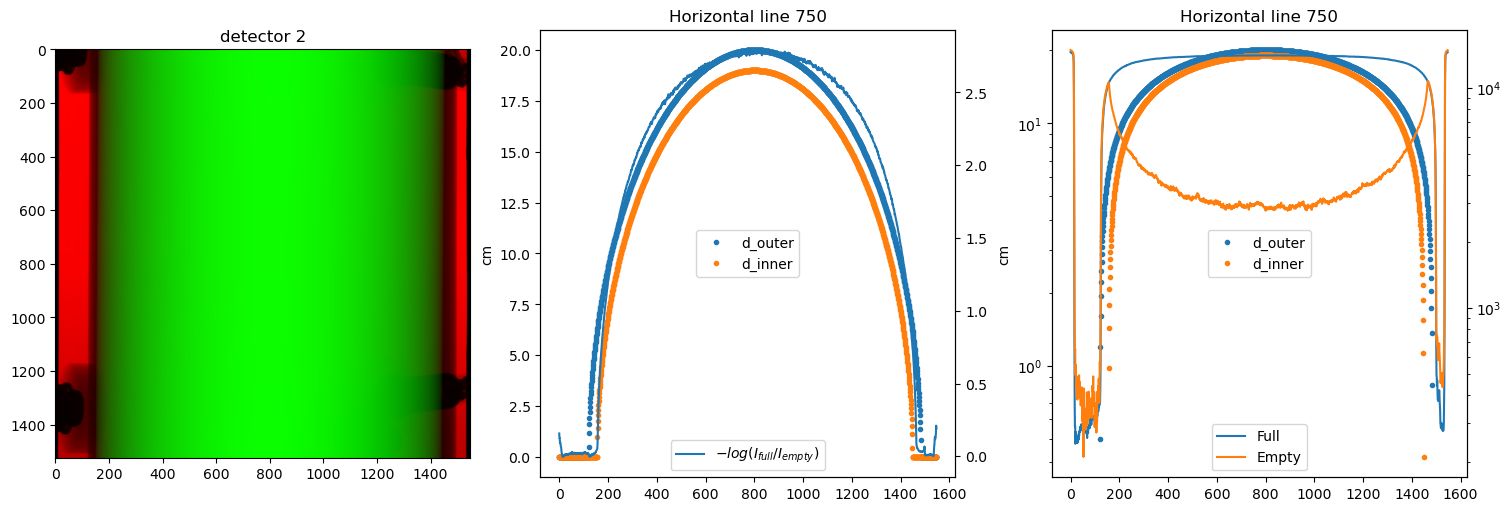

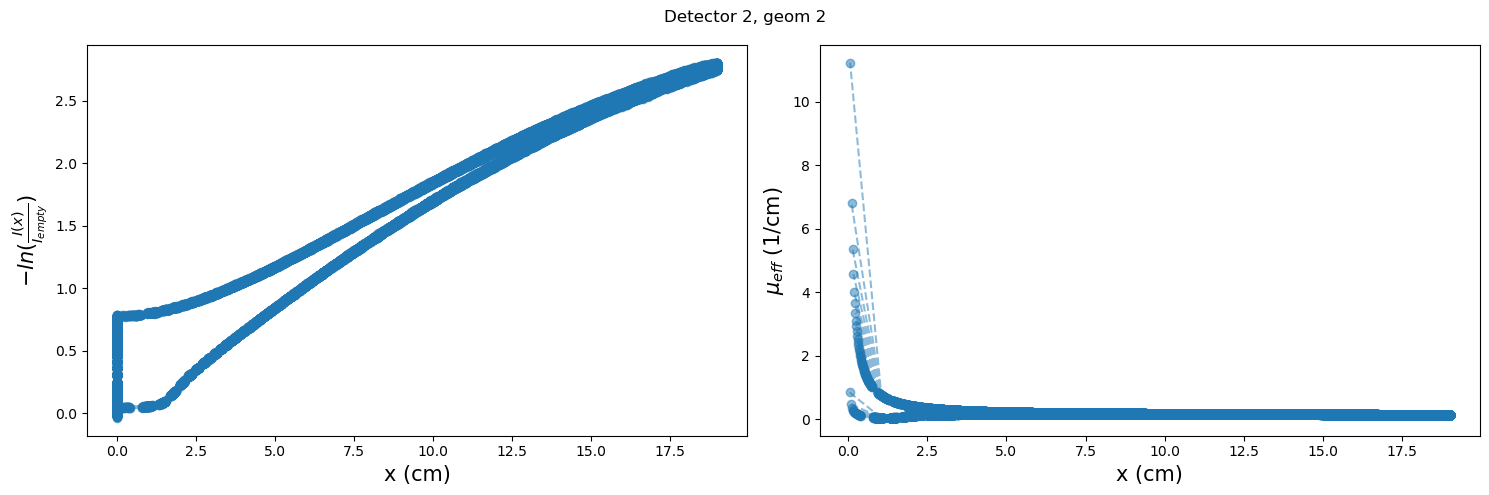

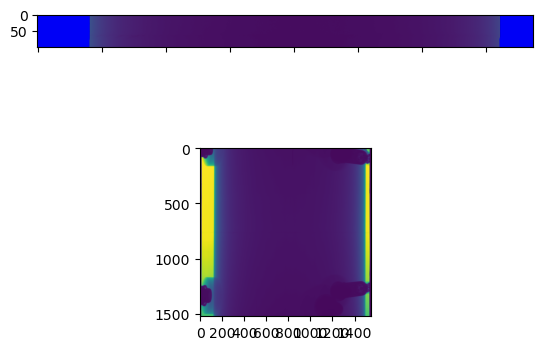

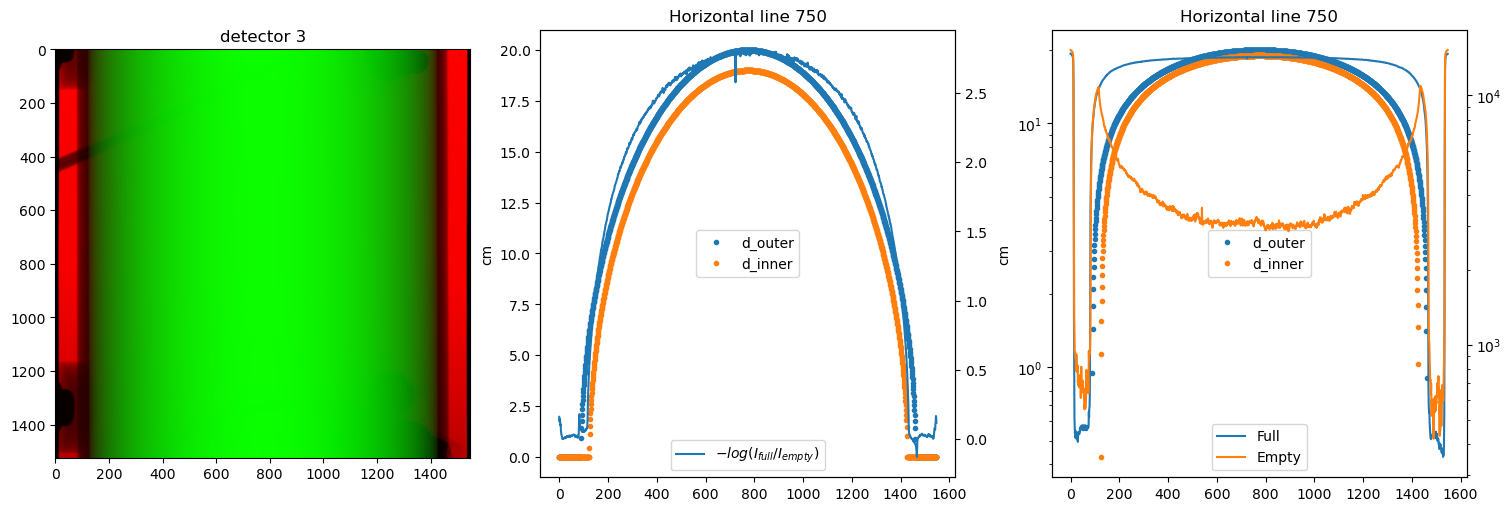

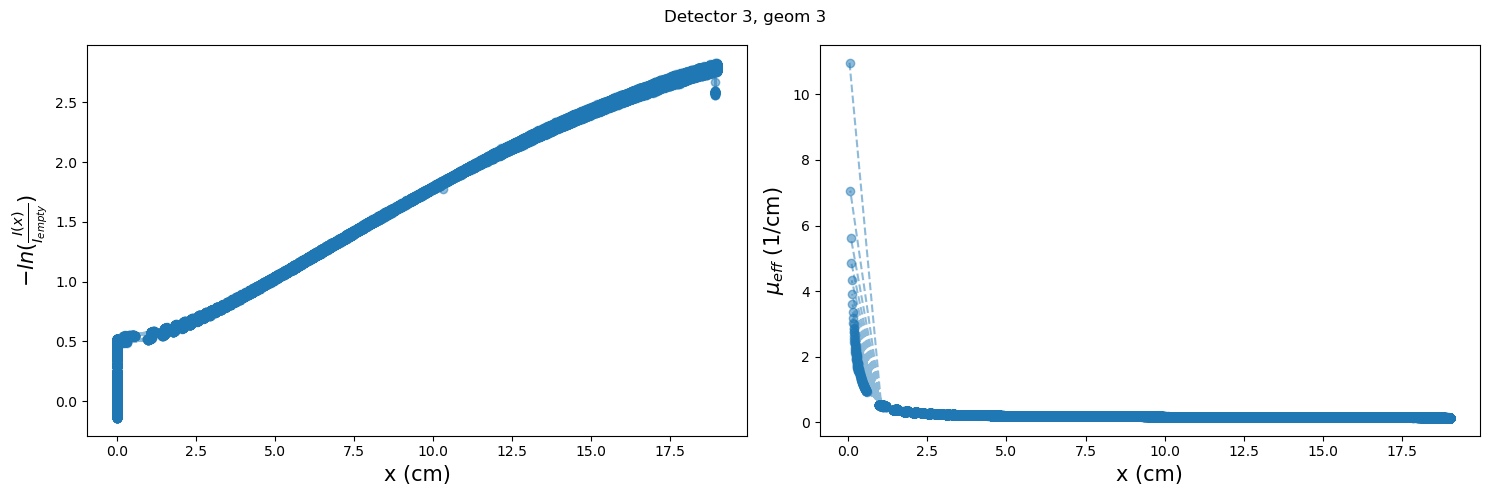

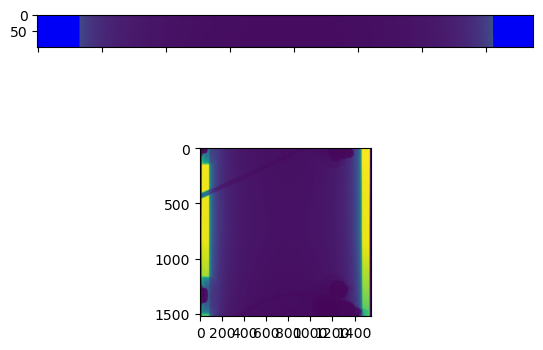

In [3]:

for cam in range(0, 3):
    # calculate distances
    single_cam_analysis(geoms_all_cams, cam, cam, det, output_path, False)

C:\Users\rikvolger\Codebase\3ct-tools\src\tri_ct_tools\preprocess\beam_hardening.py:216: RuntimeWarning: divide by zero encountered in log
  ln_intensity = -np.log(image_full / image_empty)
C:\Users\rikvolger\Codebase\3ct-tools\src\tri_ct_tools\preprocess\beam_hardening.py:265: RuntimeWarning: divide by zero encountered in divide
  effective_attenuation = ln_intensity / mean_distance
C:\Users\rikvolger\Codebase\3ct-tools\src\tri_ct_tools\preprocess\beam_hardening.py:265: RuntimeWarning: invalid value encountered in divide
  effective_attenuation = ln_intensity / mean_distance


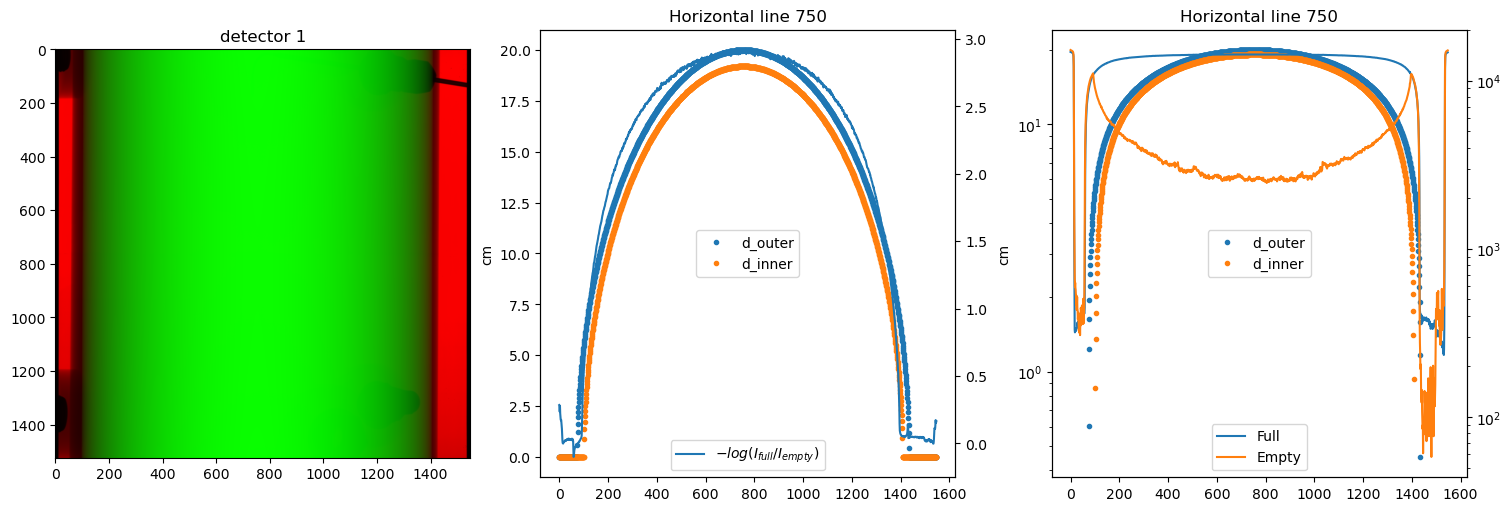

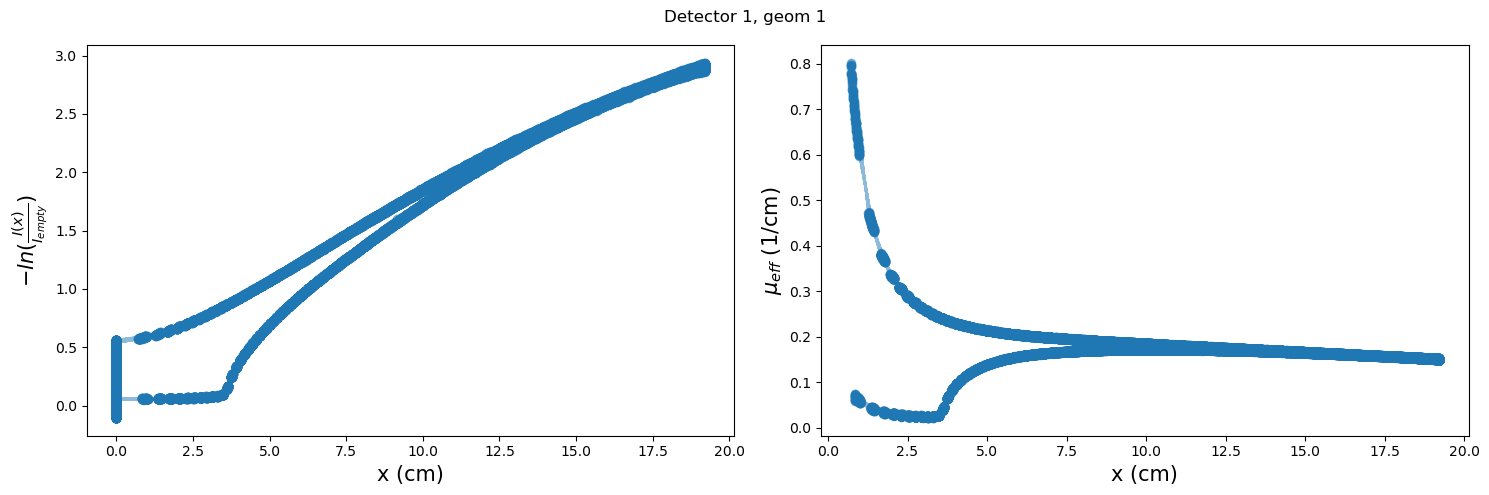

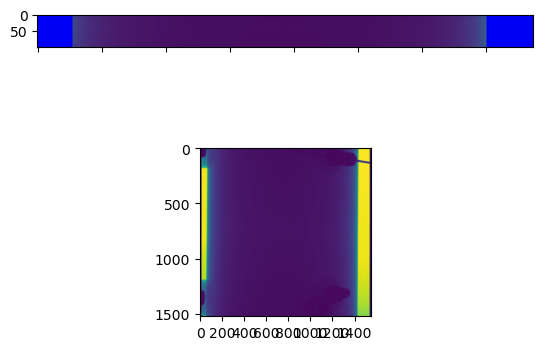

In [6]:
img_cam = 0
geom_cam = 0
single_cam_analysis(geoms_all_cams, geom_cam, img_cam, det, output_path, False)

In [ ]:
img_cam = 1
geom_cam = 0
single_cam_analysis(geoms_all_cams, geom_cam, img_cam, det, output_path, True)

In [ ]:
variables = ["srcX", "srcY", "srcZ", "dX", "dY", "dZ", "uX", "uY", "uZ", "vX", "vY", "vZ"]
print(", ".join([f"{v}: {g:> .2f}" for v, g in zip(variables, geoms_all_cams[0])]))
print(", ".join([f"{v}: {g:> .2f}" for v, g in zip(variables, geoms_all_cams[1])]))
print(", ".join([f"{v}: {g:> .2f}" for v, g in zip(variables, geoms_all_cams[2])]))



In [ ]:

for cam in range(0,3):
    
    rows, cols = det['rows'], det['cols']
    ( srcX, srcY, srcZ, dX, dY, dZ, uX, uY, uZ, vX, vY, vZ ) = geoms_all_cams[cam]
    x_coords, y_coords, z_coords = pixel_coordinates(dX, dY, dZ, uX, uY, uZ, vX, vY, vZ, rows, cols)
    d = d_through_column(x_coords, y_coords, z_coords, srcX, srcY, srcZ, det, diameter_type='inner')

    np.save(f'distances_cam{cam+1}.npy', d)
    # ( srcX, srcY, srcZ, dX, dY, dZ, uX, uY, uZ, vX, vY, vZ ) = geoms_all_cams[cam] # for camera 1?????? coordinates of source (src), coordinates of detector (d), 
                                                                                # the vector from detector pixel (0,0) to (0,1) (u),  the vector from detector pixel (0,0) to (1,0) (v)

    # rows, cols = det['rows'], det['cols']
    # print(f'dX = {dX}')
    # print(f'dY = {dY}')
    # print(f'dZ = {dZ}')

    # Compute the 3D coordinates for all pixels
    # x_coords, y_coords, z_coords = compute_all_pixel_coordinates(dX, dY, dZ, uX, uY, uZ, vX, vY, vZ, rows, cols)

    # d = calc_distance_through_column(x_coords, y_coords, z_coords, srcX, srcY, srcZ, det) # distance through water (inner diameter) for all pixels
    d_outer = d_through_column(x_coords, y_coords, z_coords, srcX, srcY, srcZ, det, diameter_type='outer') # distance through water+column (outer diameter) for all pixels
    # all_numbers = np.arange(50,220) # all frames that are taken into account
    # Initialize variables

    # image_count = len(all_numbers)
    path_full = Path(R'U:\Xray RPT ChemE\X-ray\Xray_data\2025-06-26 Rik\03_scattercorrected\1500x1500Crop_Full_120kV_22Hz', f"camera {cam+1}") # column filled with water
    image_array = np.array(Image.open(path_full / 'average.tif'), dtype=np.float64)

    path_empty = Path(R'u:\Xray RPT ChemE\X-ray\Xray_data\2025-06-26 Rik\03_scattercorrected\1500x1500Crop_Empty_120kV_22Hz', f"camera {cam+1}") # empty column
    
    image_array_empty = np.array(Image.open(path_empty / 'average.tif'), dtype=np.float64)
    
    row_start = 550
    row_end = 650

    if cam == 0:
        col_start = 56#60#120 #60
        col_end = 1436#1500#1000 # 1500
    elif cam == 1:
        col_start = 122
        col_end = 1498
    elif cam == 2:
        col_start = 76
        col_end = 1470
    else:
        col_start = 1
        col_end = -1


    #distance = d[row_start:row_end,col_start:col_end].flatten()
    # mean_distance = d[row_start:row_end, col_start:col_end].mean(axis=0).flatten() # distance through water (inner diameter)
    mean_distance = d[row_start:row_end, col_start:col_end].flatten() # distance through water (inner diameter)

    # mean_distance_outer = d_outer[row_start:row_end, col_start:col_end].mean(axis=0).flatten() # through water+column (outer diameter)
    mean_distance_outer = d_outer[row_start:row_end, col_start:col_end].flatten() # through water+column (outer diameter)

    distance_through_column = mean_distance_outer - mean_distance

    ratio_column_water = distance_through_column / mean_distance_outer
    # ratio_column_water = np.divide(
    #     distance_through_column, 
    #     mean_distance, 
    #     out=np.full_like(distance_through_column, np.nan),  # Default to NaN where division is invalid
    #     where=mean_distance != 0
    # )
    # print(ratio_column_water.mean())

    ####I_empty = image_array_empty[row_start:row_end,col_start:col_end].flatten() - image_array_scatter_empty[row_start:row_end,col_start:col_end].flatten() # correct for scatter
    # I_empty = image_array_empty[row_start:row_end,col_start:col_end].mean(axis=0).flatten() - intensity_scatter_empty # correct for scatter 
    # I_full = image_array[row_start:row_end,col_start:col_end].mean(axis=0).flatten() - intensity_scatter_full

    # I_empty = image_array_empty[row_start:row_end,col_start:col_end].mean(axis=0).flatten() 
    # I_full = image_array[row_start:row_end,col_start:col_end].mean(axis=0).flatten()
    I_empty = image_array_empty[row_start:row_end,col_start:col_end].flatten() 
    I_full = image_array[row_start:row_end,col_start:col_end].flatten()

    #lnII = -np.log((image_array[row_start:row_end,col_start:col_end].flatten()- image_array_scatter_full[row_start:row_end,col_start:col_end].flatten())/I_empty) # I0 is I_empty
    ln_intensity = -np.log(I_full/I_empty) # I0 is I_empty

    result = pd.DataFrame()
    result['distance_liquid'] = mean_distance
    result['distance_column'] = distance_through_column
    result['ratio'] = ratio_column_water
    result['-ln_intensity'] = ln_intensity
    result['I_empty'] = I_empty
    result['I_full'] = I_full
    result.to_csv('intensity.csv')

    fig, ax = plt.subplots(1,2, figsize=(15,5))
    fig.suptitle(f"Detector {cam+1}")
    ax[0].plot(mean_distance, ln_intensity, '--o', alpha=0.5)#, alpha=0.5, s=5)
    ax[0].set_xlabel('x (cm)', fontsize=15)
    ax[0].set_ylabel(r'$-ln(\frac{I(x)}{I_{empty}})$', fontsize=15)


    # mu = np.dot(distance, lnII) / np.dot(distance, distance)

    # y_pred = mu * distance
    # #plt.plot(distance, y_pred)


    # def baur(x, a, b, c):
    #     epsilon = 1e-10  # Small constant to avoid division by zero
    #     mu = a + b / (x**c + epsilon)
    #     lnII = mu * x
    #     return lnII

    # def sse(params, x, y):
    #     a, b, c = params
    #     y_pred = baur(x, a, b, c)
    #     return np.sum((y - y_pred) ** 2)

    # initial_guess = [-0.8, 1.2, 0.1]

    # # Minimize the SSE
    # result = minimize(sse, initial_guess, args=(distance, lnII), method='Nelder-Mead')

    # # Extract the fitted parameters
    # a_fit, b_fit, c_fit = result.x
    # print(f'a = {a_fit}, b = {b_fit}, alpha = {c_fit}')

    # # popt, pcov = curve_fit(baur, distance, lnII, p0=[-0.8, 1.2, 0.1])
    # # a_fit, b_fit, c_fit = popt
    # all_x = np.linspace(0.1,20, 100)
    # all_y = baur(all_x, a_fit, b_fit, c_fit)

    # #ax[0].plot(all_x, all_y)
    # print(single_height_distance)
    #ax[1].plot(all_x, all_y/all_x)
    ax[1].plot(mean_distance, ln_intensity/mean_distance, '--o', alpha=0.5)
    ax[1].set_xlabel('x (cm)', fontsize=15)
    ax[1].set_ylabel(r'$\mu_{eff}$'+' (1/cm)', fontsize=15)

    plt.tight_layout()
    plt.show()

    plt.plot(mean_distance, ratio_column_water)
    plt.ylabel(r'$x_{wall}/x_{liquid}$')
    plt.xlabel(r'$x_{liquid}$' + '(cm)')
    plt.show()
# plt.plot(image_array[700, :])
# plt.show()
# d


    # Define the value range
    min_value = 16000
    max_value = 20000

    # col_start = 1
    # col_end = -1

    # Find the locations where the values fall within the range
    #points = np.where((image_array[200:600,100:1500] >= min_value) & (image_array[200:600,100:1500] <= max_value))
    points = np.where((image_array[row_start:row_end,col_start:col_end] >= min_value) & (image_array[row_start:row_end,col_start:col_end] <= max_value))
    #no_column = np.where((d[200:600,100:1500]==0))# & (image_array[200:600,100:1500] >= min_value) & (image_array[200:600,100:1500] <= max_value))
    no_column = np.where((d[row_start:row_end,col_start:col_end]==0))

    plt.imshow(image_array[row_start:row_end,col_start:col_end])#, cmap='gray')

    # Overlay red dots on the points where the values are between 2500 and 6000
    plt.scatter(points[1], points[0], color='red', marker='o', s=5)  # Red dots for values in range
    plt.scatter(no_column[1], no_column[0], color='blue', marker='o', s=5, alpha=0.1)



    plt.show()

    # print(image_array.shape); print(d.shape)
    # print(image_array[200,0:10]); print(d[0,0:5])
    # print(image_array[50,10])

    plt.imshow(image_array)
    plt.show()

In [ ]:
#########################################################################

## To plot the geometry of the system    
plot_full_geom(geoms_all_cams, det)

#########################################################################
